In [76]:
import torch
import torch.nn as nn
import numpy as np
from tqdm.autonotebook import tqdm
from polar import PolarCode,get_frozen
from reliability_sequence import Reliability_Sequence
from utils import errors_ber,errors_bler
import matplotlib.pyplot as plt
import os

In [77]:
n = 5
N = 2**n 
K = 16
snr = 1
batch_size = 64
num_samples = 1000

torch.manual_seed(42)

In [168]:

def create_data(num_samples, n, K, snr,rs):
    """
    Create a reproducible polar code dataset
    
    Parameters:
    - num_samples: Total number of samples to generate
    - batch_size: Batch size for data generation
    - n: Polar code parameter
    - K: Information bit length
    - snr: Signal-to-Noise Ratio
    - rs: Reliability Sequence

    Returns:
    - Saved .npz file with dataset
    """

    msg_bits_list = []
    bpsk_list = []
    codeword_list = []
    corrupted_codeword_list = []
    
    polar = PolarCode(n, K, rs = rs, use_cuda=False,hard_decision=True)
    # Loop to generate data samples
    for i in range(num_samples):
        msg_bits = (torch.rand(K) > 0.5).float()
        bpsk = 1 - 2 * msg_bits

        codeword = polar.encode(bpsk.unsqueeze(0)).squeeze(0)
        corrupted_codewords = polar.channel(codeword.unsqueeze(0), snr).squeeze(0)

        msg_bits_list.append(msg_bits.cpu().numpy())
        bpsk_list.append(bpsk.cpu().numpy())
        codeword_list.append(codeword.cpu().numpy())
        corrupted_codeword_list.append(corrupted_codewords.cpu().numpy())

        msg_bits_array = np.stack(msg_bits_list)
        bpsk_array = np.stack(bpsk_list)
        codeword_array = np.stack(codeword_list)
        corrupted_codeword_array = np.stack(corrupted_codeword_list)

    filename = f"polar_dataset_N{2**n}_K{K}_SNR{snr}.npz"
    np.savez(filename, msg_bits=msg_bits_array, corrupted_codeword=corrupted_codeword_array, bpsk=bpsk_array, codeword=codeword_array)
    print(f"Dataset saved as {filename}")
    

In [169]:
create_data(num_samples,n,K,snr,rs=Reliability_Sequence)

Dataset saved as polar_dataset_N16_K8_SNR1.npz


In [78]:
data = np.load('data_rs\polar_dataset_N32_K16_SNR1.npz')

In [79]:
msg_bits = data['msg_bits']
corrupted_codeword = data['corrupted_codeword']
bpsk = data['bpsk']
codeword = data['codeword']

In [80]:
print(f"msg_bits shape: {msg_bits.shape}")
print(f"corrupted_codeword shape: {corrupted_codeword.shape}")
print(f"bpsk shape: {bpsk.shape}")
print(f"codeword shape: {codeword.shape}")


msg_bits shape: (1000, 16)
corrupted_codeword shape: (1000, 32)
bpsk shape: (1000, 16)
codeword shape: (1000, 32)


In [81]:

polar = PolarCode(n, K, rs = Reliability_Sequence, use_cuda=False,hard_decision=True)
device = 'cpu'
ber_SC_total=0
bler_SC_total=0
decoded_messages = []
SC_llrs_list = []

for bpsk_bits, corrupted_word in tqdm(zip(bpsk, corrupted_codeword),total=len(bpsk)):
    bpsk_tensor = torch.tensor(bpsk_bits, dtype=torch.float32,device=device).unsqueeze(0)
    corrupted_codeword_tensor = torch.tensor(corrupted_word, dtype=torch.float32,device=device).unsqueeze(0)

    SC_llrs, decoded_SC_msg_bits = polar.sc_decode_new(corrupted_codeword_tensor, snr=snr)
  
    decoded_messages.append(decoded_SC_msg_bits.squeeze(0).cpu().numpy())
    SC_llrs_list.append(SC_llrs.squeeze(0).cpu().numpy())
    ber_SC = errors_ber(bpsk_tensor,decoded_SC_msg_bits.sign()).item()
    bler_SC = errors_bler(bpsk_tensor,decoded_SC_msg_bits.sign()).item()

    ber_SC_total+=ber_SC
    bler_SC_total+=bler_SC

filename = f"decodedbits_N{2**n}_K{K}_SNR{snr}.npz"
np.savez(f"decodedbits_N{2**n}_K{K}_SNR{snr}.npz", decoded_msg_bits = decoded_messages, sc_llrs = SC_llrs_list)

100%|██████████| 1000/1000 [00:53<00:00, 18.86it/s]


In [82]:
ber_SC_total/len(bpsk),bler_SC_total/len(bpsk)

(0.1069375, 0.264)

In [83]:
decoded_data = np.load('decodedbits_N32_K16_SNR1.npz')

In [84]:
decoded_data

NpzFile 'decodedbits_N32_K16_SNR1.npz' with keys: decoded_msg_bits, sc_llrs

In [85]:
decoded_msg_bits = decoded_data['decoded_msg_bits']
SC_llrs = decoded_data['sc_llrs']

In [86]:
decoded_msg_bits.shape

(1000, 16)

In [168]:
class PolarDataset(torch.utils.data.Dataset):
    def __init__(self,data,data_decoded):
        polar = PolarCode(n, K, rs = Reliability_Sequence, Fr=None, use_cuda=False, hard_decision=True)
        self.msg_bits = torch.tensor(data['msg_bits'])
        self.bpsk = torch.tensor(data['bpsk'])
        self.corrupted_codeword = torch.tensor(data['corrupted_codeword'])
        self.codeword = torch.tensor(data['codeword'])

        self.decoded_bits = torch.tensor(data_decoded['decoded_msg_bits'])
        self.sc_llrs = torch.tensor(data_decoded['sc_llrs'])

        encoded_msg_bits_decoded = polar.encode(self.decoded_bits)

        self.new_data = torch.cat([
            encoded_msg_bits_decoded.unsqueeze(-1)/2,
            self.corrupted_codeword.unsqueeze(-1)
            ],dim=-1) #[N,2]
        
        # self.new_data_2 = torch.cat([
        #     self.decoded_bits,
        #     self.corrupted_codeword],dim=-1) #[N,2]
        
    def __len__(self):
        return len(self.msg_bits)
    
    def __getitem__(self, idx):
        return {
            'msg_bits': self.msg_bits[idx],
            'bpsk': self.bpsk[idx],
            'corrupted_codeword': self.corrupted_codeword[idx],
            'codeword': self.codeword[idx],
            'decoded_msg_bits': self.decoded_bits[idx],
            're_encoded_msg_bits':self.new_data[idx],
            # 're_encoded_samefeature':self.new_data_2[idx],
            'SC_llrs': self.sc_llrs[idx]
        }

In [169]:
dataset = PolarDataset(data,decoded_data)

In [170]:
BATCH_SIZE=64

In [171]:
# dataloader = torch.utils.data.DataLoader(dataset,batch_size=64,shuffle=True)
dataset_size = len(dataset)
train_size = int(0.9*dataset_size)
test_size = dataset_size - train_size

train_dataset, test_dataset = torch.utils.data.random_split(dataset,[train_size,test_size])
train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

# Print sizes of train and test sets
print(f"Train dataset size: {len(train_dataset)}")
print(f"Test dataset size: {len(test_dataset)}")


Train dataset size: 900
Test dataset size: 100


In [172]:
batch = next(iter(train_dataloader))
batch['re_encoded_msg_bits'].shape, batch['msg_bits'].shape

(torch.Size([64, 32, 2]), torch.Size([64, 16]))

In [183]:
class PolarNet(nn.Module):
    def __init__(self,hidden_channels,K):
        super().__init__()

        self.cnn = nn.Conv2d(1,hidden_channels,kernel_size = (1,2),stride=1)
        # self.fc = nn.Linear(hidden_channels * N, K)
        self.fc1 = nn.Linear(hidden_channels*N,hidden_channels*2)
        self.dropout = nn.Dropout(p=0.5)
        self.bn1 = nn.BatchNorm1d(hidden_channels*2)
        self.fc2 = nn.Linear(hidden_channels*2,K)

    def forward(self,x):
        x = x.unsqueeze(1) #[B,C,N,2]
        # print(x.shape)
        x = torch.nn.functional.gelu(self.cnn(x)) #[B,128,32,1]
        x = x.squeeze(-1) #[B,hidden_channels,32]
        x = x.view(x.shape[0], -1)
        # x = self.dropout(x)
        # x = self.fc(x)
        x = torch.nn.functional.gelu(self.bn1(self.fc1(x))) 
        x = self.dropout(x)
        x = self.fc2(x)
        return x

In [194]:
device = 'cuda'
model = PolarNet(hidden_channels=64,K=K).to(device)
criterion = nn.BCEWithLogitsLoss()
# criterion = nn.HingeEmbeddingLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

In [195]:
def calculate_ber_bler(targets,predictions):
    """ Calculate BER and BLER using errors_ber and errors_bler functions. """
    ber = errors_ber(targets, predictions.sign()).item()
    bler = errors_bler(targets, predictions.sign()).item()
    return ber, bler

In [196]:
num_epochs = 1000
patience = 5  # Early stopping patience
best_loss = float('inf')
trigger_times = 0

polar = PolarCode(n, K, rs = Reliability_Sequence, use_cuda=True,hard_decision=True)
loss_values = []
ber_values = []
bler_values=[]
for epoch in range(num_epochs):
    model.train()
    total_loss, total_ber, total_bler = 0, 0, 0

    for batch in train_dataloader:
        msg_bits = batch['msg_bits'].to(device)
        re_encoded_msg_bits = batch['re_encoded_msg_bits'].to(device)    
  
        optimizer.zero_grad()
        final_predictions = model(re_encoded_msg_bits.to(device))
        # predicted_bits = torch.sigmoid(final_predictions)
        predicted_bits = (final_predictions>=0).float()
        
        bce_loss = criterion(final_predictions, msg_bits)
        loss = bce_loss
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
        ber, bler = calculate_ber_bler(msg_bits,predicted_bits)
        total_ber += ber
        total_bler += bler

    # Compute average loss and error rates
    avg_loss = total_loss / len(train_dataloader)
    avg_ber = total_ber / len(train_dataloader)
    avg_bler = total_bler / len(train_dataloader)

    loss_values.append(avg_loss)
    ber_values.append(avg_ber)
    bler_values.append(avg_bler)

    # Early stopping check
    if avg_loss < best_loss:
        best_loss = avg_loss
        trigger_times = 0
        
        ckpt_path = rf'weights_rs\N_{N}_K_{K}_SNR_{snr}_polarnet'
        os.makedirs(ckpt_path,exist_ok=True)
        torch.save(model.state_dict(), os.path.join(ckpt_path,f'epoch_{epoch}.pth'))
    # else:
    #     trigger_times += 1
    #     if trigger_times >= patience:
    #         print("Early stopping triggered!")
    #         break

    # Logging progress every 3 epochs
    if (epoch + 1) % 100 == 0:
        print(f"Epoch {epoch + 1}/{num_epochs}, Loss: {avg_loss:.4f}, BER: {avg_ber:.4f}, BLER: {avg_bler:.4f}")

print("Training complete.")



Epoch 100/1000, Loss: 0.5472, BER: 0.2780, BLER: 0.9958
Epoch 200/1000, Loss: 0.5010, BER: 0.2445, BLER: 0.9896
Epoch 300/1000, Loss: 0.4912, BER: 0.2372, BLER: 0.9812
Epoch 400/1000, Loss: 0.4598, BER: 0.2210, BLER: 0.9750
Epoch 500/1000, Loss: 0.4417, BER: 0.2058, BLER: 0.9760
Epoch 600/1000, Loss: 0.4169, BER: 0.1924, BLER: 0.9521
Epoch 700/1000, Loss: 0.4185, BER: 0.1996, BLER: 0.9635
Epoch 800/1000, Loss: 0.4097, BER: 0.1910, BLER: 0.9563
Epoch 900/1000, Loss: 0.3850, BER: 0.1801, BLER: 0.9458
Epoch 1000/1000, Loss: 0.3786, BER: 0.1730, BLER: 0.9396
Training complete.


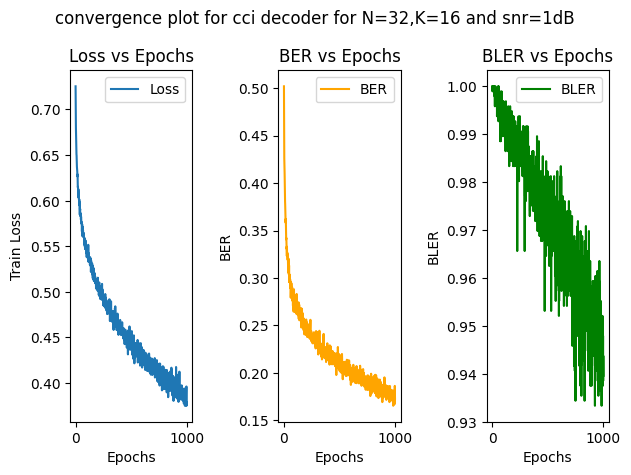

In [197]:
plt.suptitle('convergence plot for cci decoder for N=32,K=16 and snr=1dB')
# Plot Loss vs Epochs
plt.subplot(1, 3, 1)
plt.plot(loss_values, label='Loss')
plt.title('Loss vs Epochs')
plt.xlabel('Epochs')
plt.ylabel('Train Loss')
plt.legend()

# Plot BER vs Epochs
plt.subplot(1, 3, 2)
plt.plot(ber_values, label='BER', color='orange')
plt.title('BER vs Epochs')
plt.xlabel('Epochs')
plt.ylabel('BER')
plt.legend()

# Plot BLER vs Epochs

plt.subplot(1, 3, 3)
plt.plot(bler_values, label='BLER', color='green')
plt.title('BLER vs Epochs')
plt.xlabel('Epochs')
plt.ylabel('BLER')
plt.legend()

plt.tight_layout()
plt.show()

In [199]:
model.load_state_dict(torch.load(r'weights_rs\N_32_K_16_SNR_1_polarnet\epoch_983.pth'))

<All keys matched successfully>

In [ ]:
test_ber_total,test_bler_total = 0,0
count = 0
with torch.no_grad():
    model.eval()
    for batch_idx, test_batch in enumerate(test_dataloader):
        print(batch_idx)
        count += 1
        test_msg_bits = test_batch['msg_bits'].to(device)
        test_re_encoded_msg_bits = test_batch['re_encoded_msg_bits'].to(device)   

        test_final_predictions = model(test_re_encoded_msg_bits)
        test_predicted_bits = (test_final_predictions>=0).float()
        ber,bler = calculate_ber_bler(test_msg_bits,test_predicted_bits)
        test_ber_total += ber
        test_bler_total += bler
        
        # Print sequences for debugging (every 10th batch)
        if (batch_idx + 1) % 1 == 0:
            print(f"Test Batch {batch_idx + 1}")
            print(f"Predicted bits: {test_predicted_bits.int().tolist()}")
            print(f"Ground truth: {test_msg_bits.int().tolist()}")
            if torch.all(test_predicted_bits == test_msg_bits):
                print("Decoded correctly")
            else:
                print("Decoded incorrectly")
            print("----------")

test_avg_ber = test_ber_total / len(test_dataloader)
test_avg_bler =test_bler_total / len(test_dataloader)
print(f"Test Results - BER: {test_avg_ber:.4f}, BLER: {test_avg_bler:.4f}")

0
Test Batch 1
Predicted bits: [[1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1], [0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1], [0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0], [1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1], [0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0], [0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0], [0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0], [1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1], [0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1], [1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0], [1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0], [1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0], [0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1], [1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0], [0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0], [1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0], [0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1], [0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1], [1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1], [1, 1, 1, 1, 0, 0,

In [114]:
test_msg_bits.shape, test_final_predictions.shape

(torch.Size([36, 16]), torch.Size([36, 16]))

In [123]:
i=8
test_msg_bits[i],(test_final_predictions[i]>=0).float()

(tensor([1., 0., 0., 1., 1., 0., 1., 0., 1., 1., 0., 0., 0., 1., 0., 0.],
        device='cuda:0'),
 tensor([1., 0., 0., 1., 1., 0., 0., 0., 1., 1., 1., 1., 0., 0., 0., 0.],
        device='cuda:0'))